# Kinship: Compute Cumulative regret of RESCAL and BRESCAL

* Train BayesianRESCAL (BRESCAL) and RESCAL on the fully observed tensor
* Reconstruct tensor by using the trained BRESCAL and RESCAL
* At each time $t$, pull an entry of maximum value from the reconstructed tensor, and then compute the regret $r_t$

**Regrets computed by the reconstructed tensor can be considered as a lower bound (not exact) of the regret we can archive through the particle Thompson sampling**, since the tensor is reconstructed by the model trained with fully observed tensor.

In [1]:
import os
import sys
import pickle
import numpy as np
from scipy.io.matlab import loadmat
from scipy.sparse import csr_matrix
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import itertools

import rescal
from brescal import BayesianRescal
from seq_brescal import PFBayesianRescal, compute_regret

%matplotlib inline

mat = loadmat('../data/alyawarradata.mat')
T = np.array(mat['Rs'], np.float32)
T = np.swapaxes(T, 1, 2)
T = np.swapaxes(T, 0, 1)  # [relation, entity, entity]

budget = 30000
max_iter = 20
n_dim = 10
var_e = 1
var_r = 1
var_x = 0.1

X = [csr_matrix(T[k]) for k in range(T.shape[0])]
A, R, f, itr, exectimes = rescal.rescal_als(X, n_dim)
_X = np.zeros_like(T)
for k in range(T.shape[0]):
    _X[k] = np.dot(np.dot(A, R[k]), A.T)

model = BayesianRescal(n_dim, var_e=var_e, var_x=var_x, var_r=var_r)
model.fit(T, max_iter=max_iter)
_T = model._reconstruct()

seq_brescal = list()
seq_rescal = list()
for i in range(budget):
    idx = np.unravel_index(_T.argmax(), _T.shape)
    seq_brescal.append(idx)
    _T[idx] = -1000000
    idx = np.unravel_index(_X.argmax(), _X.shape)
    seq_rescal.append(idx)
    _X[idx] = -1000000

regret_brescal = compute_regret(T, seq_brescal)
regret_rescal = compute_regret(T, seq_rescal)

## Compute Cumulative Regret of Particle Thompson 

In [2]:
varxs = [0.1, 0.01]
n_dims = [5, 10]
n_particles = [5, 10, 30]
n_test = 11

dest = '../result/kinship/'
summary = dict()

for var_x, nt, n_dim, n_particle in itertools.product(varxs, range(1, n_test), n_dims, n_particles):
    file = os.path.join(dest, 'sRESCAL_varx_%.2f_dim_%d_par_%d_test_%d_convar_False.txt' % (var_x, n_dim, n_particle, nt))
    if os.path.exists(file):
        seq = [line.split(',') for line in open(file, 'r').readlines()]
        key = (var_x, n_dim, n_particle)    
        cum_sum = np.cumsum([1-T[s] for s in seq])

        if not key in summary:
            summary[key] = list()
            summary[key].append(cum_sum)
        else:
            summary[key].append(cum_sum)

/Users/arongdari/.python3/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Plot Cumulative Regret 

0:pThompson_x0.10_d5_p30:	Iteration:   670	Regret: 584.0
1:pThompson_x0.10_d5_p5:	Iteration: 30000	Regret: 24456.4
2:pThompson_x0.10_d10_p30:	Iteration:   444	Regret: 399.9
3:pThompson_x0.10_d5_p10:	Iteration: 28554	Regret: 23725.3
4:pThompson_x0.01_d5_p10:	Iteration: 22241	Regret: 19424.0
5:pThompson_x0.01_d5_p30:	Iteration:   669	Regret: 580.5
6:pThompson_x0.01_d5_p5:	Iteration: 30000	Regret: 26245.0
7:pThompson_x0.10_d10_p10:	Iteration: 20683	Regret: 15177.6
8:pThompson_x0.01_d10_p5:	Iteration: 13638	Regret: 11154.8
9:pThompson_x0.01_d10_p10:	Iteration: 17981	Regret: 15118.5
10:pThompson_x0.10_d10_p5:	Iteration: 30000	Regret: 22612.1
11:pThompson_x0.01_d10_p30:	Iteration:   441	Regret: 414.2
BRESCAL:	Iteration: 30000	Regret: 20517.0
RESCAL:		Iteration: 30000	Regret: 20323.0


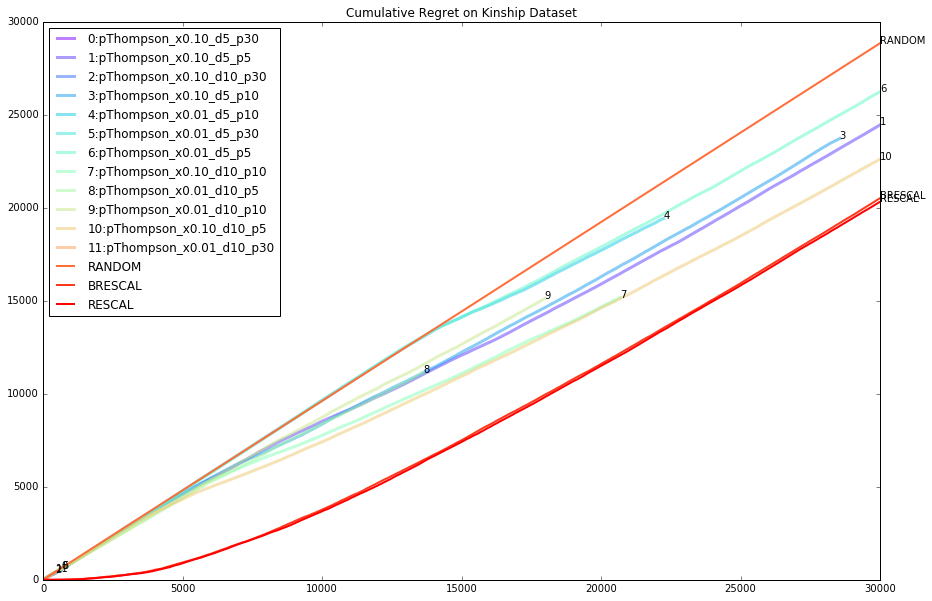

In [3]:
fig = plt.figure(figsize=(15,10))
color=iter(plt.cm.rainbow(np.linspace(0,1,len(summary)+3)))
markers = iter(MarkerStyle.markers.keys())

for line_no, key in enumerate(summary.keys()):
    min_len = 999999999
    for cum_sum in summary[key]:
        if len(cum_sum) < min_len:
            min_len = len(cum_sum)
    stat = np.zeros([len(summary[key]), min_len])
    for i, cum_sum in enumerate(summary[key]):
        stat[i] = cum_sum[:min_len]
        
    mean = np.mean(stat, 0)
    stderr = yerr=np.std(stat, 0)
    plt.plot(mean, label='%d:pThompson_x%.2f_d%d_p%d' % (line_no, key[0], key[1], key[2]), 
             color=next(color), linewidth=3, alpha=0.5)
    plt.annotate(str(line_no), xy=(len(mean), mean[-1]))
    #plt.fill_between(range(len(mean)), mean-stderr, mean+stderr, alpha=0.3, color=c)
    print('%d:pThompson_x%.2f_d%d_p%d:\tIteration: %5d\tRegret: %5.1f' % (line_no, key[0], key[1], key[2], min_len, mean[-1]))

print('BRESCAL:\tIteration: %5d\tRegret: %5.1f' % (len(regret_brescal), np.cumsum(regret_brescal)[-1]))
print('RESCAL:\t\tIteration: %5d\tRegret: %5.1f' % (len(regret_brescal), np.cumsum(regret_rescal)[-1]))

ratio = np.sum(T)/np.prod(T.shape)
cum_sum = np.cumsum([1. - ratio for i in range(budget)])
plt.plot(cum_sum, label='RANDOM', color=next(color), linewidth=2)
plt.annotate('RANDOM', xy=(len(cum_sum), cum_sum[-1]))
plt.plot(np.cumsum(regret_brescal), label='BRESCAL', color=next(color), linewidth=2)
plt.annotate('BRESCAL', xy=(len(regret_brescal), np.cumsum(regret_brescal)[-1]))
plt.plot(np.cumsum(regret_rescal), label='RESCAL', color=next(color), linewidth=2)
plt.annotate('RESCAL', xy=(len(regret_rescal), np.cumsum(regret_rescal)[-1]))

plt.legend(loc=0)
plt.title('Cumulative Regret on Kinship Dataset')
plt.show()

All results are averaged over 10 individual runs. 
In general, 

* the models with 10 particles perform better than those with 5 particles. 
* And the models with 0.1 variance on observed data points perform better than those with 0.01 variance.

*Models with 30 particles are running now.*

## Plot Regret with One Standard Error

For clear representations, we only plot the cases where the number of particles is equal to 10.

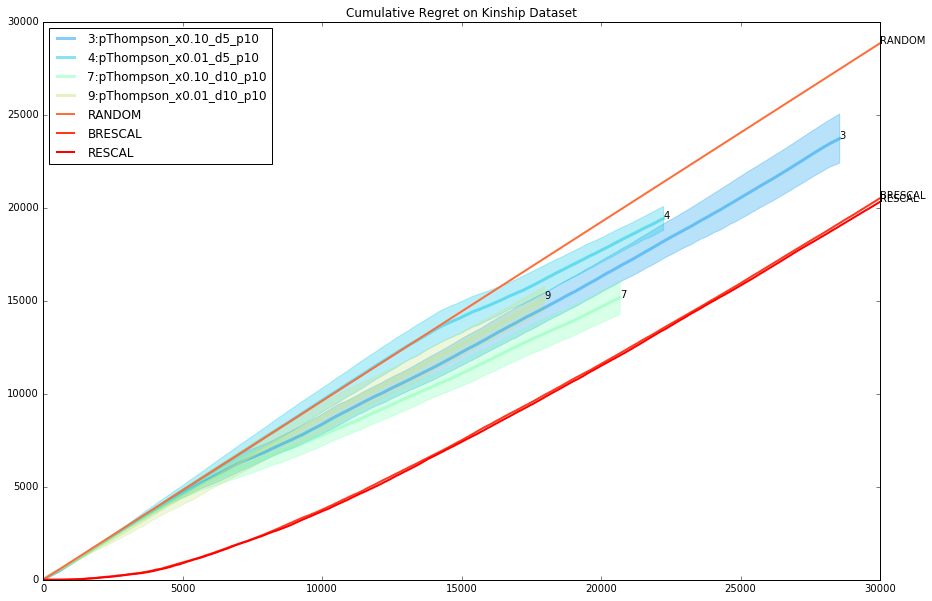

In [9]:
fig = plt.figure(figsize=(15,10))
color=iter(plt.cm.rainbow(np.linspace(0,1,len(summary)+3)))
markers = iter(MarkerStyle.markers.keys())

for line_no, key in enumerate(summary.keys()):
    min_len = 999999999
    for cum_sum in summary[key]:
        if len(cum_sum) < min_len:
            min_len = len(cum_sum)
    stat = np.zeros([len(summary[key]), min_len])
    for i, cum_sum in enumerate(summary[key]):
        stat[i] = cum_sum[:min_len]
    c=next(color)    
    if key[2] == 10:
        mean = np.mean(stat, 0)
        stderr = yerr=np.std(stat, 0)
        plt.plot(mean, label='%d:pThompson_x%.2f_d%d_p%d' % (line_no, key[0], key[1], key[2]), 
                 color=c, linewidth=3, alpha=0.5)
        plt.annotate(str(line_no), xy=(len(mean), mean[-1]))
        plt.fill_between(range(len(mean)), mean-stderr, mean+stderr, alpha=0.3, color=c)

ratio = np.sum(T)/np.prod(T.shape)
cum_sum = np.cumsum([1. - ratio for i in range(budget)])
plt.plot(cum_sum, label='RANDOM', color=next(color), linewidth=2)
plt.annotate('RANDOM', xy=(len(cum_sum), cum_sum[-1]))
plt.plot(np.cumsum(regret_brescal), label='BRESCAL', color=next(color), linewidth=2)
plt.annotate('BRESCAL', xy=(len(regret_brescal), np.cumsum(regret_brescal)[-1]))
plt.plot(np.cumsum(regret_rescal), label='RESCAL', color=next(color), linewidth=2)
plt.annotate('RESCAL', xy=(len(regret_rescal), np.cumsum(regret_rescal)[-1]))

plt.legend(loc=0)
plt.title('Cumulative Regret on Kinship Dataset')
plt.show()